# 레이더 자료 내려받기와 시각화하기
- Nexrad level 3
- https://www.roc.noaa.gov/wsr88d/Level_III/Level3Info.aspx
- https://www.ncdc.noaa.gov/data-access/radar-data/nexrad
- https://www.ncdc.noaa.gov/data-access/radar-data/nexrad-products 참조
- 미국 자료이지만 평택의 레이더 자료 사용 가능

# 레이더 자료 받기
- https://unidata.github.io/siphon/latest/examples/Radar_Server_Level_3.html 참조

In [14]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np


from siphon.radarserver import get_radarserver_datasets, RadarServer
from siphon.cdmr import Dataset

In [15]:
ds = get_radarserver_datasets('http://thredds.ucar.edu/thredds/')
print(list(ds))

['NEXRAD Level II Radar for Case Study CCS039', 'NEXRAD Level II Radar from IDD', 'NEXRAD Level III Radar for Case Study CCS039', 'NEXRAD Level III Radar from IDD', 'TDWR Level III Radar from IDD']


In [16]:
url = ds['NEXRAD Level III Radar from IDD'].follow().catalog_url
rs = RadarServer(url)

자료 변수 목록
https://www.weather.gov/media/tg/rpccds_radar_products.pdf

In [17]:
print(rs.variables)

{'N1M', 'N2K', 'N3S', 'NST', 'DTA', 'N3M', 'N3H', 'N0K', 'N3U', 'DU3', 'NVW', 'N0Q', 'N0S', 'N0X', 'NBU', 'NVL', 'N1S', 'N3X', 'NAU', 'N0V', 'N2C', 'NAH', 'N2S', 'NAX', 'HHC', 'N2X', 'NAM', 'NBX', 'N0Z', 'NAC', 'DAA', 'NBQ', 'OHA', 'NBH', 'DSD', 'NMD', 'NAK', 'NBK', 'NAQ', 'N3C', 'N3K', 'NTP', 'N0C', 'PTA', 'DSP', 'N1X', 'NBM', 'N2U', 'NCR', 'N0M', 'DPA', 'DU6', 'N1H', 'N2H', 'NET', 'N2Q', 'N1K', 'N3Q', 'N0U', 'N1C', 'N1P', 'N0R', 'N0H', 'EET', 'DHR', 'DVL', 'N1Q', 'DPR', 'DOD', 'N2M', 'NBC', 'N1U'}


In [18]:
query = rs.query()
query.stations('KSG').time(datetime(2020,11,19,0)).variables('N0Q','N0U')
rs.validate_query(query)
# 관측지점 정보: https://www.roc.noaa.gov/WSR88D/Maps.aspx
# 우리나라 평택:KSG, 군산:KJK (미군 기지)

True

In [19]:
query.variables()

var=N0U&var=N0Q&time=2020-11-19T00%3A00%3A00&stn=KSG

In [20]:
catalog = rs.get_catalog(query)
print(catalog.datasets)

['Level3_KSG_N0Q_20201119_0002.nids', 'Level3_KSG_N0U_20201119_0002.nids']


In [33]:
ds1 = list(catalog.datasets.values())[0] # base reflectivity
ds2 = list(catalog.datasets.values())[1] # raidal velocity
print(ds1.access_urls)
data1 = Dataset(ds1.access_urls['CdmRemote'])
data2 = Dataset(ds2.access_urls['CdmRemote'])

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/nexrad/level3/IDD/N0Q/KSG/20201119/Level3_KSG_N0Q_20201119_0002.nids', 'HTTPServer': 'https://thredds.ucar.edu/thredds/fileServer/nexrad/level3/IDD/N0Q/KSG/20201119/Level3_KSG_N0Q_20201119_0002.nids', 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/nexrad/level3/IDD/N0Q/KSG/20201119/Level3_KSG_N0Q_20201119_0002.nids'}


In [34]:
data2.variables

OrderedDict([('elevation', <siphon.cdmr.dataset.Variable at 0x24d5229ab88>),
             ('azimuth', <siphon.cdmr.dataset.Variable at 0x24d5229a788>),
             ('gate', <siphon.cdmr.dataset.Variable at 0x24d5229a508>),
             ('latitude', <siphon.cdmr.dataset.Variable at 0x24d5229a708>),
             ('longitude', <siphon.cdmr.dataset.Variable at 0x24d5229aa48>),
             ('altitude', <siphon.cdmr.dataset.Variable at 0x24d5229a408>),
             ('rays_time', <siphon.cdmr.dataset.Variable at 0x24d5229ac88>),
             ('BaseVelocityDV_RAW',
              <siphon.cdmr.dataset.Variable at 0x24d52299808>),
             ('BaseVelocityDV',
              <siphon.cdmr.dataset.Variable at 0x24d522998c8>)])

# 레이더 자료 시각화 하기
- https://unidata.github.io/siphon/latest/examples/Radar_Server_Level_3.html
- https://nbviewer.jupyter.org/gist/dopplershift/356f2e14832e9b676207 참조
- 레이더 반사도와 시선속도

In [60]:
import metpy.plots as mpplots
ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5)
vel_norm, vel_cmap = mpplots.ctables.registry.get_with_steps('NWSVelocity', 5, 5)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [59]:
import numpy as np
def raw_to_masked_float(var):

    # Mask missing points
    var = np.ma.array(var, mask=var==0)

    return var

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [97]:
rng = data1.variables['gate'][:] /1000.
az = data1.variables['azimuth'][:]
ref = data1.variables['BaseReflectivityDR'][:]
ref = raw_to_masked_float(ref)
x1, y1 = polar_to_cartesian(az, rng)

rng = data2.variables['gate'][:] /1000.
az = data2.variables['azimuth'][:]
vel = data2.variables['BaseVelocityDV'][:]
vel = raw_to_masked_float(vel)
x2, y2 = polar_to_cartesian(az, rng)


C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


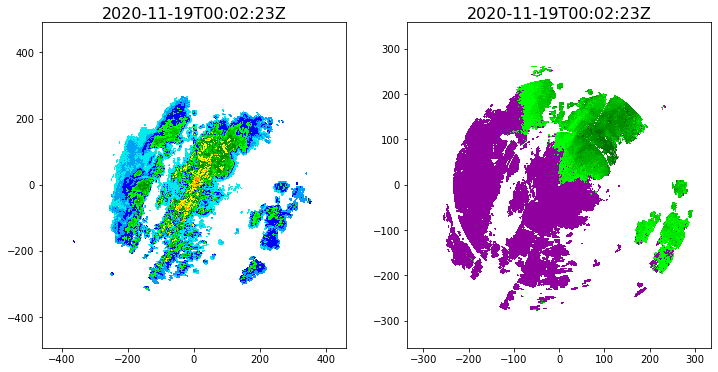

In [108]:
fig = plt.figure(figsize=(12, 6))

# Base reflectivity
ax = fig.add_subplot(121)
ax.set_aspect('equal', 'datalim')
ax.pcolormesh(x1, y1, ref, cmap=ref_cmap, norm=ref_norm)
ax.set_xlim(-460, 460)
ax.set_ylim(-460, 460)
text = ax.set_title(data.time_coverage_start, transform=ax.transAxes,
                   fontsize=16)

# Base radial velocity
ax2 = fig.add_subplot(122)
ax2.set_aspect('equal', 'datalim')
mesh2 = ax2.pcolormesh(x2, y2, vel, cmap=vel_cmap, norm=vel_norm)
ax2.set_xlim(-360, 360)
ax2.set_ylim(-360, 360)
text = ax2.set_title(data.time_coverage_start, transform=ax2.transAxes,
                   fontsize=16)

plt.show()